In [1]:
import pandas as pd
import numpy as np

In [2]:
original_df = pd.read_csv('data.csv')
original_df = original_df.drop(columns=['Formatted Date'])
original_df.rename(columns={'Daily Summary': 'label'}, inplace= True)
original_df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),label
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
import numbers

# convert categorical data to numerical labels
def normalize_fun(min, max, val, factor=1):
    denom = max - min
    nem = (val - min) * factor
    if denom != 0:
        return nem / denom
    else:
        return 0.0

def normalize(row):
    min = row.min()
    max = row.max()
    for index, value in row.items():
        value = float(value)
        row[index] = normalize_fun(min, max, value, 100)
    return row

def conversion_fn(row):
    if row.size > 0:
        process = isinstance(row.iloc[0], numbers.Number)
        if not process:
            # print('process this')
            labels = []
            for index, value in row.items():
                if value not in labels:
                    labels.append(value)
                row[index] = labels.index(value)
            return normalize(row).astype(float)
            # return row
        else:
            return normalize(row)
            # return row

def numberic_conversion(df):
    return df.apply(conversion_fn, axis=0)

In [4]:
df = numberic_conversion(original_df.copy().head(2000))

In [5]:
def seperate_input_output(df):
    return df.drop(columns=['label']), pd.DataFrame(df, columns=['label'])

In [6]:
X, y = seperate_input_output(df)

In [7]:
def euclidian_distance(pt1, pt2):
    diff = pt1 - pt2
    return np.sqrt(np.dot(diff, diff))
def angle(pt1, pt2):
    inner = np.inner(pt1, pt2)
    norm = np.linalg.norm(pt1) * np.linalg.norm(pt2)
    cos = inner / norm
    rad =  np.arccos(np.clip(cos, -1.0, 1.0))
    return np.rad2deg(rad)

In [8]:
def cost_matrix(data):
    h, _ = data.shape
    # print(h)
    cost_matrix = np.zeros((h, h))
    for x in range(h):
        for y in range(x, h):
            # dist = euclidian_distance(data.iloc[x], data.iloc[y])
            dist = euclidian_distance(data.iloc[x], data.iloc[y])
            cost_matrix[x][y], cost_matrix[y][x] = dist, dist
    return cost_matrix

In [9]:
# using prim's algorithm for minimum spanning tree
def mst(data):
    h, _ = data.shape
    INF = 9999999
    cm = cost_matrix(data)
    # print(cm)
    snode = np.zeros(h)
    nedges = 0
    snode[0] = True

    palist = []
    pblist = []
    cost = []
    while nedges < h - 1:
        min = INF
        a, b = 0, 0
        for m in range(h):
            if snode[m]:
                for n in range(h):
                    if (not snode[n]) and cm[m][n]:
                        # not in selected and there is an edge
                        if min > cm[m][n]:
                            min = cm[m][n]
                            a = m
                            b = n
        # print(str(a) + "-" + str(b) + ":" + str(cm[a][b]))
        palist.append(a)
        pblist.append(b)
        cost.append(cm[a][b])
        snode[b] = True
        nedges += 1
    srtd = sorted(zip(cost, zip(palist, pblist)))
    edges = [st[1] for st in srtd]
    cst = [st[0] for st in srtd]
    return edges, cst, srtd
# edges, cst, _ = mst(X)
# print(edges)

In [10]:
def draw_tree(st_pt, pcst, edges, cst, agl, visited):
    tree = []
    for index in range(len(edges)):
        tup = edges[index]
        if st_pt == tup[0] and st_pt not in visited:
            np.append(visited, st_pt)
            nxt_ind = tup[1]
            tree.append((nxt_ind, (pcst + cst[index], agl[index])))
            tree = tree + draw_tree(nxt_ind, pcst + cst[index], edges, cst, agl, visited)
    return tree
def get_cart_points(data):
    edges, cst, _ = mst(data)
    agl = [angle(data.iloc[edge[0]], data.iloc[edge[1]]) for edge in edges]
    visited = np.array([])
    tree = [(0, (0,0))]
    tree = tree + draw_tree(0, 0, edges, cst, agl, visited)
    return tree
cart_point = get_cart_points(X.head(100))
cart_point

[(0, (0, 0)),
 (1, (4.97854764751687, 1.46784443173816)),
 (5, (10.660264488691508, 1.3110233076271143)),
 (3, (11.416312180112442, 1.8723925687966667)),
 (4, (26.931481817629127, 4.748700512690625)),
 (74, (44.36102830436266, 4.978452944538951)),
 (96, (64.8551091640475, 5.909188914152072)),
 (97, (78.28746858756864, 4.129701124779507)),
 (2, (70.47684319312907, 8.318836257998841)),
 (23, (93.45968343524581, 6.657970779632262)),
 (22, (109.5668096148606, 5.094458963958036)),
 (28, (125.03116732051664, 5.002467434059363)),
 (27, (139.2503334074751, 4.678314026021112)),
 (29, (155.1412538184206, 5.188789162636714)),
 (94, (191.9382659649376, 12.468873547238925)),
 (95, (210.1944391020239, 6.308806324887587)),
 (93, (242.42360580403803, 10.854663270767455)),
 (63, (276.79681549582654, 10.686292538944064)),
 (61, (310.7574501286685, 11.707847148884909)),
 (50, (283.6112000896627, 14.928066574850227)),
 (76, (300.8725227878291, 5.972259977468443)),
 (73, (325.3771584015415, 8.3917426252978

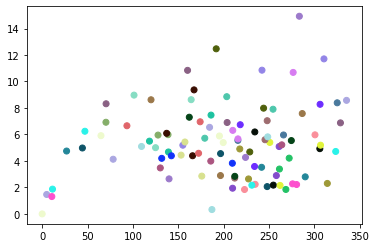

In [11]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def random_colors(size):
    return ["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)]) for j in range(size)]
def plot_map(points, labels):
    x = []
    y = []
    uniq_labels = np.unique(labels)
    total_labels = len(uniq_labels)
    colors = random_colors(total_labels)

    # legends
    fig, ax = plt.subplots()
    patches = []
    for i in range(total_labels):
        color = colors[i]
        label = i
        patch = mpatches.Patch(color=color, label=label)
        patches.append(patch)
    # ax.legend(handles=patches)

    color = []
    for point in points:
        id = point[0]
        x.append(point[1][0])
        y.append(point[1][1])
        color_id = id % total_labels
        color.append(colors[color_id])

    plt.scatter(x, y, c=color)
plot_map(cart_point, y)

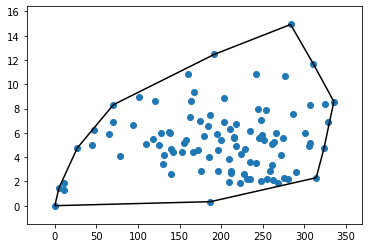

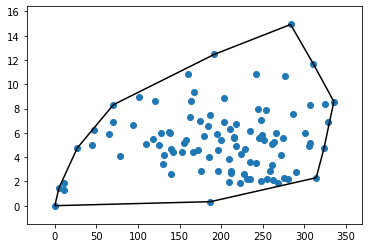

In [12]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull_points = []
for point in cart_point:
    hull_points.append([point[1][0], point[1][1]])
hull = ConvexHull(hull_points)
convex_hull_plot_2d(hull)